In [1]:
# Configure to use JAX internally
# import jax
# jax.config.update("jax_enable_x64", True)
# jax.config.update("jax_platform_name", "cpu")
# from qiskit_dynamics.array import Array
# Array.set_default_backend("numpy")
#
# Array.default_backend()

In [2]:
import pprint
from time import time

from IPython.display import display, Markdown
import numpy as np

from qiskit import pulse
from qiskit.providers.fake_provider import FakeManila
from qiskit_dynamics import DynamicsBackend
from qiskit_experiments.framework import BackendData

In [3]:
fake_backend = FakeManila()
config = fake_backend.configuration()
props = fake_backend.properties()
data = BackendData(fake_backend)

print(
    "================================================================================"
)
print("FAKE MANILA")
print(
    "================================================================================"
)
print(f"Number of qubits: {config.n_qubits:.0f}")
print(f"Input signal timestep: {config.dt*1e9:.3f} ns")
print(f"Granularity: {data.granularity:.3f}")
print(f"Acquire alignment: {data.acquire_alignment:.3f}")
print(f"Pulse alignment: {data.pulse_alignment:.3f}")
lcm = np.lcm(data.acquire_alignment, data.pulse_alignment)
print(f"Least common multiple of acquire_alignment and pulse_alignment: {lcm}")
print(f"Resonant frequency for qubit 0: {props.frequency(0)*1e-9:.3f} GHz")
print(f"T1 time for qubit 0: {props.t1(0)*1e6:.3f} microseconds")
print(f"T2 time for qubit 0: {props.t2(0)*1e6:.3f} microseconds")
print(f"U2 gate error for qubit 0: {props.gate_error('sx', 0):.6f}")
print(f"U2 gate duration for qubit 0: {props.gate_length('sx', 0)*1e9:.3f} nanoseconds")
print(
    "================================================================================"
)
display(Markdown(rf"""{config.hamiltonian["description"]}"""))
display(Markdown(rf"""$${config.hamiltonian["h_latex"]}$$"""))
print(
    "================================================================================"
)

FAKE MANILA
Number of qubits: 5
Input signal timestep: 0.222 ns
Granularity: 1.000
Acquire alignment: 1.000
Pulse alignment: 1.000
Least common multiple of acquire_alignment and pulse_alignment: 1
Resonant frequency for qubit 0: 4.963 GHz
T1 time for qubit 0: 109.187 microseconds
T2 time for qubit 0: 5.077 microseconds
U2 gate error for qubit 0: 0.003866
U2 gate duration for qubit 0: 35.556 nanoseconds


Qubits are modeled as Duffing oscillators. In this case, the system includes higher energy states, i.e. not just |0> and |1>. The Pauli operators are generalized via the following set of transformations:

$(\mathbb{I}-\sigma_{i}^z)/2 \rightarrow O_i \equiv b^\dagger_{i} b_{i}$,

$\sigma_{+} \rightarrow b^\dagger$,

$\sigma_{-} \rightarrow b$,

$\sigma_{i}^X \rightarrow b^\dagger_{i} + b_{i}$.

Qubits are coupled through resonator buses. The provided Hamiltonian has been projected into the zero excitation subspace of the resonator buses leading to an effective qubit-qubit flip-flop interaction. The qubit resonance frequencies in the Hamiltonian are the cavity dressed frequencies and not exactly what is returned by the backend defaults, which also includes the dressing due to the qubit-qubit interactions.

Quantities are returned in angular frequencies, with units 2*pi*GHz.

WARNING: Currently not all system Hamiltonian information is available to the public, missing values have been replaced with 0.


$$\begin{align} \mathcal{H}/\hbar = & \sum_{i=0}^{4}\left(\frac{\omega_{q,i}}{2}(\mathbb{I}-\sigma_i^{z})+\frac{\Delta_{i}}{2}(O_i^2-O_i)+\Omega_{d,i}D_i(t)\sigma_i^{X}\right) \\ & + J_{0,1}(\sigma_{0}^{+}\sigma_{1}^{-}+\sigma_{0}^{-}\sigma_{1}^{+}) + J_{1,2}(\sigma_{1}^{+}\sigma_{2}^{-}+\sigma_{1}^{-}\sigma_{2}^{+}) + J_{2,3}(\sigma_{2}^{+}\sigma_{3}^{-}+\sigma_{2}^{-}\sigma_{3}^{+}) + J_{3,4}(\sigma_{3}^{+}\sigma_{4}^{-}+\sigma_{3}^{-}\sigma_{4}^{+}) \\ & + \Omega_{d,0}(U_{0}^{(0,1)}(t))\sigma_{0}^{X} + \Omega_{d,1}(U_{1}^{(1,0)}(t)+U_{2}^{(1,2)}(t))\sigma_{1}^{X} \\ & + \Omega_{d,2}(U_{3}^{(2,1)}(t)+U_{4}^{(2,3)}(t))\sigma_{2}^{X} + \Omega_{d,3}(U_{6}^{(3,4)}(t)+U_{5}^{(3,2)}(t))\sigma_{3}^{X} \\ & + \Omega_{d,4}(U_{7}^{(4,3)}(t))\sigma_{4}^{X} \\ \end{align}$$

In [14]:
cutoff = 1.5 * props.frequency(0)
dynamic_backend = DynamicsBackend.from_backend(
    backend=fake_backend,
    subsystem_list=[0],
    # evaluation_mode="sparse",
    rwa_cutoff_freq=cutoff,
)

ValueError: setting an array element with a sequence.

In [11]:
sigma = 128
num_samples = 256

schedules = []

for amp in np.linspace(0.0, 1.0, 10):
    gauss = pulse.library.Gaussian(num_samples, amp, sigma, name="Parametric Gauss")

    with pulse.build() as schedule:
        with pulse.align_sequential():
            pulse.play(gauss, pulse.DriveChannel(0))
            pulse.shift_phase(0.5, pulse.DriveChannel(0))
            pulse.shift_frequency(0.1, pulse.DriveChannel(0))
            pulse.play(gauss, pulse.DriveChannel(0))
            pulse.acquire(duration=1, qubit_or_channel=0, register=pulse.MemorySlot(0))

    schedules.append(schedule)

start = time()
job = dynamic_backend.run(schedules, shots=100)
result = job.result()
end = time()
print(f"Executed dynamic backend in {end - start:.3f} seconds.")

Executed dynamic backend in 48.795 seconds.


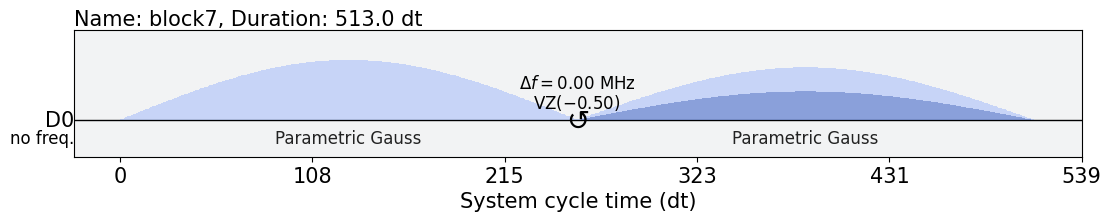

In [6]:
schedules[3].draw()

In [7]:
result.get_counts(3)

{'0': 31, '1': 69}